In [1]:
from pythtb import Lattice, TBModel, Mesh, WFArray, Wannier
from axion import axion_angle_3form, fin_diff
from pythtb.utils import levi_civita, finite_diff_coeffs
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

In [2]:
lat_vecs = [[0, 1, 1], [1, 0, 1], [1, 1, 0]]
orb_vecs = [[0, 0, 0], [0.25, 0.25, 0.25]]
lat = Lattice(lat_vecs, orb_vecs, periodic_dirs=[0, 1, 2])

fkm_model = TBModel(lattice=lat, spinful=True)

t = 1.0
soc = 1/4
m = 1/2

fkm_model.set_onsite(
    lambda beta: [0, m*np.sin(beta), m*np.sin(beta), m*np.sin(beta)],
    ind_i=0,
)
fkm_model.set_onsite(
    lambda beta: [0, -m*np.sin(beta), -m*np.sin(beta), -m*np.sin(beta)],
    ind_i=1,
)

# spin-independent first-neighbor hops
for lvec in ([-1, 0, 0], [0, -1, 0], [0, 0, -1]):
    fkm_model.set_hop(t, 0, 1, lvec)

fkm_model.set_hop(
    lambda beta: 3 * t + m * np.cos(beta), 
    0, 1, [0, 0, 0], mode="set")

# spin-dependent second-neighbor hops
lvec_list = ([1, 0, 0], [0, 1, 0], [0, 0, 1], [-1, 1, 0], [0, -1, 1], [1, 0, -1])
dir_list = ([0, 1, -1], [-1, 0, 1], [1, -1, 0], [1, 1, 0], [0, 1, 1], [1, 0, 1])
for j in range(6):
    spin = np.array([0.0] + dir_list[j])
    fkm_model.set_hop(1j * soc * spin, 0, 0, lvec_list[j])
    fkm_model.set_hop(-1j * soc * spin, 1, 1, lvec_list[j])

print(fkm_model)

----------------------------------------
       Tight-binding model report       
----------------------------------------
r-space dimension           = 3
k-space dimension           = 3
periodic directions         = [0, 1, 2]
spinful                     = True
number of spin components   = 2
number of electronic states = 4
number of orbitals          = 2

Lattice vectors (Cartesian):
  # 0 ===> [ 0.000,  1.000,  1.000]
  # 1 ===> [ 1.000,  0.000,  1.000]
  # 2 ===> [ 1.000,  1.000,  0.000]
Volume of unit cell (Cartesian) = 2.000 [A^d]

Reciprocal lattice vectors (Cartesian):
  # 0 ===> [-3.142,  3.142,  3.142]
  # 1 ===> [ 3.142, -3.142,  3.142]
  # 2 ===> [ 3.142,  3.142, -3.142]
Volume of reciprocal unit cell = 124.025 [A^-d]

Orbital vectors (Cartesian):
  # 0 ===> [ 0.000,  0.000,  0.000]
  # 1 ===> [ 0.500,  0.500,  0.500]

Orbital vectors (fractional):
  # 0 ===> [ 0.000,  0.000,  0.000]
  # 1 ===> [ 0.250,  0.250,  0.250]
----------------------------------------
Site energies:


In [3]:
### Adiabatic parameters
# k space
nks = 30, 30, 30

# lambda space
n_beta = 51
max_beta = 2*np.pi
betas = np.linspace(0, max_beta, n_beta, endpoint=True) 

########### Useful model information ###########
recip_lat_vecs = fkm_model.recip_lat_vecs  # Reciprocal lattice vectors (Cartesian)
n_spin = fkm_model.nspin   # Number of spins
n_orb = fkm_model.norb     # Number of orbitals
n_states = n_spin * n_orb   # Total number of states
n_occ = n_states//2         # Number of occupied states

n_param = nks + (n_beta,)    # Number of points in 4d mesh
dim_k = fkm_model.dim_k      # Number of k-space dimensions (3)
dim_lam = 1                  # Number of adiabatic dimensions (1)
dim_total = dim_k + dim_lam  # Total number of dimensions (4)

print(f"Number of orbs: {n_orb}")
print(f"Number of spins: {n_spin}")
print("Number of states:", n_states)
print("Number of occupied bands:", n_occ)
print("(nks, nbeta):", n_param)
print("Total number of parameter points:", np.prod(n_param))

Number of orbs: 2
Number of spins: 2
Number of states: 4
Number of occupied bands: 2
(nks, nbeta): (30, 30, 30, 51)
Total number of parameter points: 1377000


In [6]:
betas_4curv, thetas_4curv, c2 = fkm_model.axion_angle(
    nks=nks, 
    param_periods={'beta': 2*np.pi},
    return_second_chern=True, 
    use_tensorflow=True,
    diff_order=8,
    beta=betas
)

In [7]:
mesh = Mesh(dim_k=3, axis_types=["k", "k", "k"])
mesh.build_grid(shape=nks)
dks = [1/nk for nk in nks]

In [17]:
def find_diff_axion(model, tf_list, nks):
    dks = [1/nk for nk in nks]

    mesh = Mesh(dim_k=3, axis_types=["k", "k", "k"])
    mesh.build_grid(shape=nks)
    dks = [1/nk for nk in nks]

    print("Solving model...")
   
    wfa = WFArray(model.lattice, mesh, spinful=model.spinful)
    wfa.solve_model(model, use_tensorflow=True)

    print("Getting smooth gauge...")
    wannier = Wannier(wfa)
    wannier.project(tf_list)
    tilde_wfs = wannier.tilde_states

    print("Computing Berry connection in smooth gauge...")
    A_tilde = tilde_wfs.berry_connection()
    parx_A = fin_diff(A_tilde, mu=1, dk_mu=dks[0], order_eps=1, mode='forward')
    pary_A = fin_diff(A_tilde, mu=2, dk_mu=dks[1], order_eps=1, mode='forward')
    parz_A = fin_diff(A_tilde, mu=3, dk_mu=dks[2], order_eps=1, mode='forward')
    dmu_Atilde = np.array([parx_A, pary_A, parz_A])

    print("Computing theta from 3-form connection...")
    epsilon = levi_civita(3, 3)
    A_til_tf = tf.convert_to_tensor(A_tilde, tf.complex64)
    AdA = tf.einsum('i...ab,jk...ba->ijk...', A_til_tf, dmu_Atilde)
    AAA = tf.einsum('i...ab,j...bc,k...ca->ijk...', A_til_tf, A_til_tf, A_til_tf)
    integrand = tf.einsum("ijk, ijk... -> ...", epsilon, AdA - (2j/3) * AAA).numpy()
    theta_fd = -(4*np.pi)**(-1) * np.sum(integrand) * np.prod(dks)

    return theta_fd

In [9]:
thetas_3form_curv = np.zeros((betas.shape[0]))
thetas_3form_conn = np.zeros((betas.shape[0]))
thetas_3form_fd = np.zeros((betas.shape[0]))

window = 0.6

for idx, beta in enumerate(betas):
    print(f"Computing theta for beta index {idx} / {betas.shape[0]-1}")

    print("Defining model...")
    model = fkm_model.copy()
    model.set_parameters({"beta": beta})

    # trial wavefunctions of form (orbital, spin, amp)
    # buffer zone to avoid singularity at beta = pi
    if abs(beta - np.pi) < window:
        # breaks TRS in gauge to avoid topological obstruction
        print("Using TRS-breaking gauge to avoid singularity at beta = pi")
        tf_list = [ 
            [(0, 0, -1), (0, 1, 1)], 
            [(1, 0, 1), (1, 1, 1)]
            ]
    else:
        tf_list = [[(0, 0, 1), (1, 0, -1)], [(0, 1, 1), (1, 1, -1)]]

    print("Getting axion angle via Sylvester 3-form...")
    theta, theta2 = axion_angle_3form(
        model, tf_list, nks=nks, return_both=True, order_fd=11,
        use_tf_speedup=True
        )
    thetas_3form_curv[idx] = theta.real
    thetas_3form_conn[idx] = theta2.real

    theta_fd = find_diff_axion(model, tf_list, nks=nks)
    thetas_3form_fd[idx] = theta_fd.real

    print(f"idx: {idx}, beta: {beta}, theta: {theta.real}, theta_fd: {theta_fd.real}")
    print("-----")

Computing theta for beta index 0 / 50
Defining model...
Getting axion angle via Sylvester 3-form...
Min singular value of S_occ: 0.8707401517451101
Solving model...
Getting smooth gauge...
Computing Berry connection in smooth gauge...
Computing theta from 3-form connection...
idx: 0, beta: 0.0, theta: 1.0387194218968917e-17, theta_fd: 5.466597610049778e-05
-----
Computing theta for beta index 1 / 50
Defining model...
Getting axion angle via Sylvester 3-form...
Min singular value of S_occ: 0.8700490321031966
Solving model...
Getting smooth gauge...
Computing Berry connection in smooth gauge...
Computing theta from 3-form connection...
idx: 1, beta: 0.12566370614359174, theta: 0.1045717738550533, theta_fd: 0.09428016493055555
-----
Computing theta for beta index 2 / 50
Defining model...
Getting axion angle via Sylvester 3-form...
Min singular value of S_occ: 0.8678817122583363
Solving model...
Getting smooth gauge...
Computing Berry connection in smooth gauge...
Computing theta from 3-fo

In [10]:
thetas_proj_conn = np.unwrap(thetas_3form_conn)
thetas_proj_curv = np.unwrap(thetas_3form_curv)
thetas_fd = np.unwrap(thetas_3form_fd)

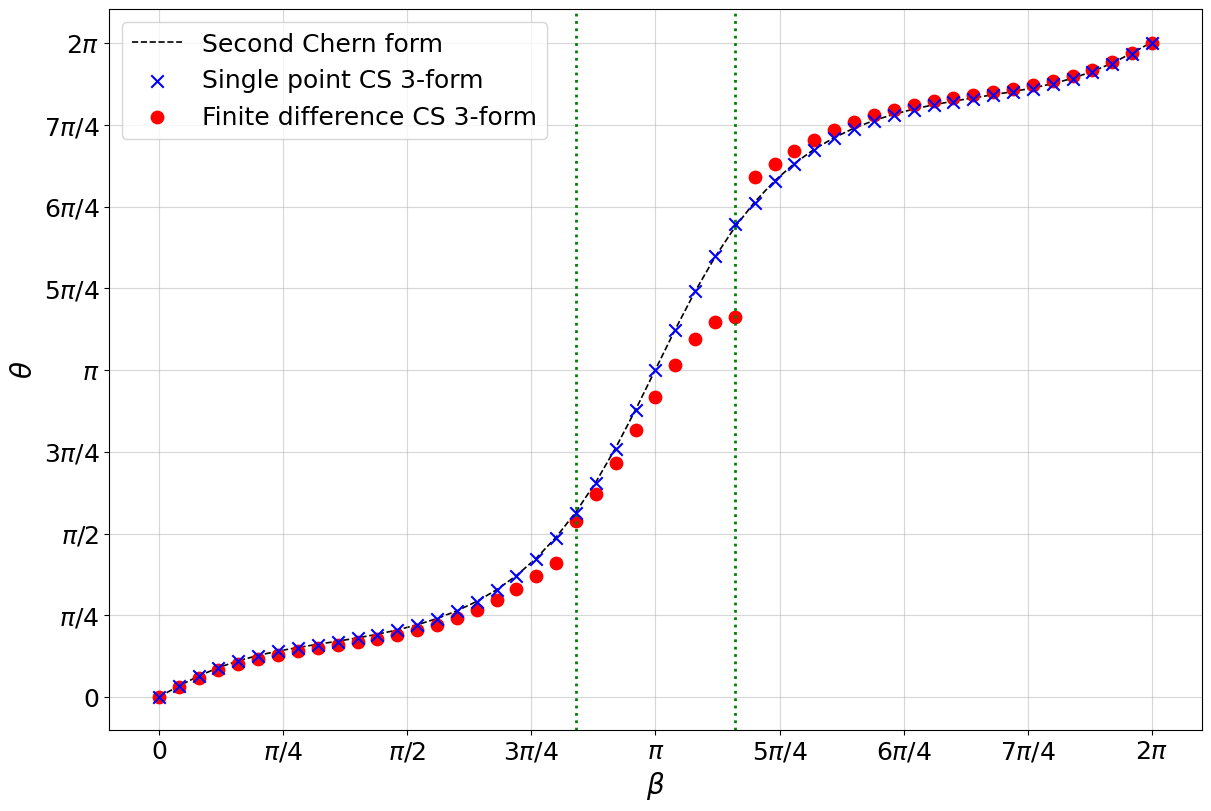

In [50]:
fig, ax = plt.subplots(figsize=(12, 8), constrained_layout=True)  # PRB single-column friendly

ax.plot(
    betas, thetas_4curv.real, 
    lw=1.2, zorder=1, c='k', ls='--',
    label=r"Second Chern form"
    )  

ax.scatter(
    betas, thetas_proj_curv, 
    s=80, c='b', zorder=3, marker='x',
    label=r"Single point CS 3-form"
    )

ax.scatter(
    betas, thetas_fd, 
    s=80, c='r', zorder=2, marker='o',
    label=r"Finite difference CS 3-form"
    )

# ax.scatter(
#     betas, thetas_proj_conn,
#     s=15, c='r', zorder=2, marker='o', 
#     label="Chern-Simons 3-form from connection"
#     )

ax.set_xlabel(r"$\beta$", size=20)
ax.set_ylabel(r"$\theta$", size=20)

mask = abs(betas - np.pi) < window
ax.axvline(betas[mask][0], ls=':', lw=2,  c='g')
ax.axvline(betas[mask][-1], ls=':', lw=2, c='g')

tick_positions = np.arange(0, 2*np.pi+np.pi/4, np.pi/4)
tick_labels = [
    r"$0$", r"$\pi/4$", r"$\pi/2$", r"$3\pi/4$", r"$\pi$", 
    r"$5\pi/4$", r"$6\pi/4$", r"$7\pi/4$", r"$2\pi$"]

ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, size=18)
ax.set_yticks(tick_positions)
ax.set_yticklabels(tick_labels, size=18)

# ax.tick_params(direction="out", length=4, width=0.9)
# ax.minorticks_on()
# ax.grid(True, which="major", alpha=0.8, linewidth=1)
# ax.grid(True, which="minor", alpha=1, linewidth=0.5)

ax.grid(alpha=0.5)
ax.legend(loc='upper left', prop={'size': 18})
# ax.set_title(fr"$N_k = ${nks}, $C_2 = {c2:.4f}$", size=15)
plt.savefig("fkm_axion_angle_comparison.png", dpi=600, bbox_inches="tight")
plt.show()

In [15]:
beta = np.pi
model = fkm_model.copy()
model.set_parameters({"beta": beta})
print(model)

----------------------------------------
       Tight-binding model report       
----------------------------------------
r-space dimension           = 3
k-space dimension           = 3
periodic directions         = [0, 1, 2]
spinful                     = True
number of spin components   = 2
number of electronic states = 4
number of orbitals          = 2

Lattice vectors (Cartesian):
  # 0 ===> [ 0.000,  1.000,  1.000]
  # 1 ===> [ 1.000,  0.000,  1.000]
  # 2 ===> [ 1.000,  1.000,  0.000]
Volume of unit cell (Cartesian) = 2.000 [A^d]

Reciprocal lattice vectors (Cartesian):
  # 0 ===> [-3.142,  3.142,  3.142]
  # 1 ===> [ 3.142, -3.142,  3.142]
  # 2 ===> [ 3.142,  3.142, -3.142]
Volume of reciprocal unit cell = 124.025 [A^-d]

Orbital vectors (Cartesian):
  # 0 ===> [ 0.000,  0.000,  0.000]
  # 1 ===> [ 0.500,  0.500,  0.500]

Orbital vectors (fractional):
  # 0 ===> [ 0.000,  0.000,  0.000]
  # 1 ===> [ 0.250,  0.250,  0.250]
----------------------------------------
Site energies:


In [16]:
tf_list = [ 
    [(0, 0, -1), (0, 1, 1)], 
    [(1, 0, 1), (1, 1, 1)]
    ]

In [ ]:
nkxs = [10, 20, 30, 40, 50, 75, 100]

# thetas_beta_pi_sp = np.zeros(len(nkxs))
# thetas_beta_pi_fd = np.zeros(len(nkxs))
thetas_beta_pi_4curv = np.zeros(len(nkxs))

for idx, nkx in enumerate(nkxs):
    nks = nkx, nkx, nkx
    print(f"Processing nks = {nks} -> Nk = {nkx**3}")

    # theta, _ = axion_angle_3form(
    #     model, tf_list, nks=nks, return_both=True, order_fd=11,
    #     use_tf_speedup=True
    #     )
    
    # theta_fd = find_diff_axion(model, tf_list, nks=nks)
    betas_4curv, thetas_4curv, c2 = fkm_model.axion_angle(
        nks=nks, 
        param_periods={'beta': 2*np.pi},
        return_second_chern=True, 
        use_tensorflow=True,
        diff_order=8,
        beta=betas
    )
    # print(f"nkx: {nkx}, theta (sp): {theta.real}, theta (fd): {theta_fd.real}")

    # thetas_beta_pi_sp[idx] = theta.real
    # thetas_beta_pi_fd[idx] = theta_fd.realP
    thetas_beta_pi_4curv[idx] = thetas_4curv[betas == beta].real
    print(f"nkx: {nkx}, theta (4curv): {thetas_4curv[betas == beta].real}")

Processing nks = (10, 10, 10) -> Nk = 1000
0.6283185307179586


ValueError: setting an array element with a sequence.

In [19]:
thetas_beta_pi_conn = np.unwrap(thetas_beta_pi_conn)
thetas_beta_pi_fd = np.unwrap(thetas_beta_pi_fd)

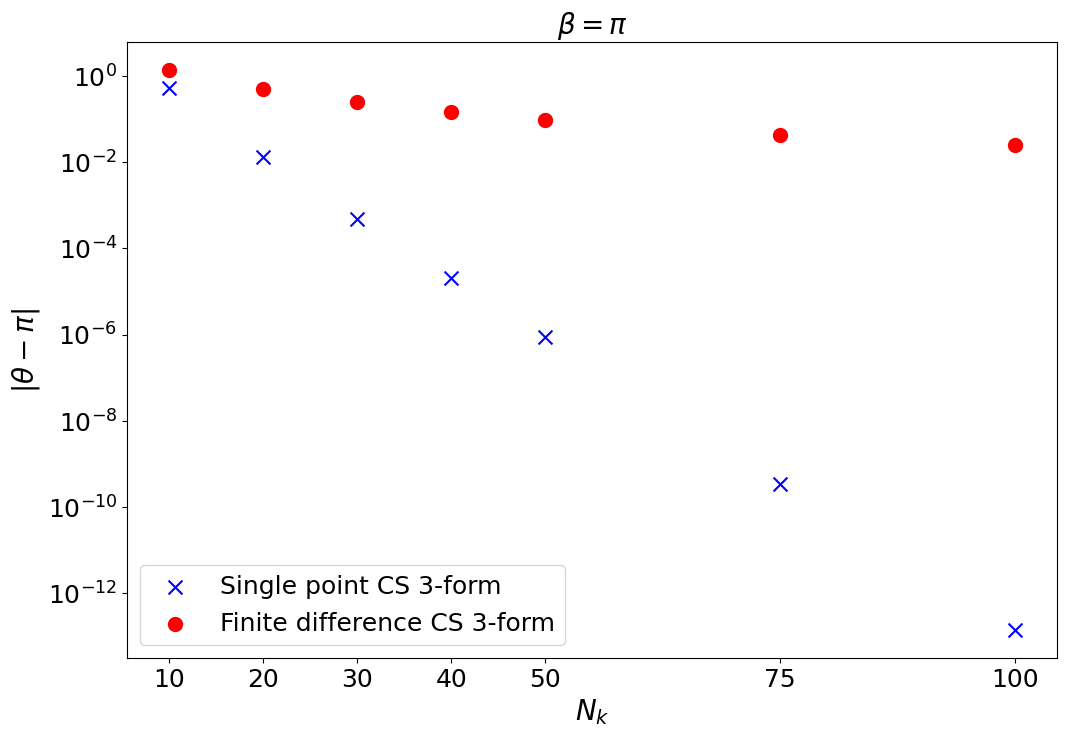

In [48]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(
    nkxs, 
    abs(thetas_beta_pi_conn - np.pi), 
    c='b', 
    s=100,
    marker='x', 
    label=r'Single point CS 3-form'
    )
ax.scatter(
    nkxs, 
    abs(thetas_beta_pi_fd - np.pi), 
    c='r', 
    s=100,
    marker='o', 
    label=r'Finite difference CS 3-form'
    )

# error
# N = np.linspace(nkxs[0], nkxs[-1], 100)
# a = 0.34
# C = abs(delta_theta_curv[0])*np.exp(a*N[0])
# fit = C*np.exp(-a * N)
# ax.plot(N[:40], fit[:40], ls='--', label=rf'${C:.2f}e^{{-{a} N_k}}$', zorder=0)

ax.set_xlabel(r'$N_{k}$', size=20)
ax.set_ylabel(r'$| \theta - \pi |$', size=20)
ax.set_title(r"$\beta = \pi$", size=20)
ax.set_xticks(nkxs)
ax.set_xticklabels([str(n) for n in nkxs], size=18)
ax.set_yticks([1e-3, 1e-2, 1e-1, 1])
ax.set_yticklabels([r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$', r'$1$'], size=18)

plt.yscale('log') 
plt.legend(loc='lower left', prop={'size': 18})
plt.savefig("fkm_axion_angle_convergence.png", dpi=600, bbox_inches="tight")